<a href="https://colab.research.google.com/github/IC-UFAL-IADD/IADD/blob/codebasics/OrgamizacaoDataset_Split_Metricas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#################################################

** Created by Prof. Dr. Marcelo Oliveira on 24/06/2021. 

** Disciplina de Fundametos de IA aplicados ao Diagnóstico de Doenças. 

** Copyright (c)2020 Instituto de Computação ** 

** Universidade Federal de Alagoas - UFAL. All rights reserved.**

################################################# 

References:

- (1) Recomenda resolucao de radiografia (between 256 × 256 and 448 × 448 pixels). The Effect of Image Resolution on Deep Learning in Radiography (https://doi.org/10.1148/ryai.2019190015)
- (2) Preparing Medical Imaging Data for Machine Learning. https://doi.org/10.1148/radiol.2020192224
- (2) Implementar a AUC no FastAI https://forums.fast.ai/t/fastai-v2-vision/53528/38
- (3) Metricas: https://asvcode.github.io/MedicalImaging/medical_imaging/dicom/model_evaluation/ppv/npv/specificity/sensitivity/2020/04/29/Starting-With-Medical-Imaging.html

### Requerimentos: pydicom, scikit-image, kornia, fastai 

*   pip install fastai --upgrade -q


In [ ]:
pip install git+https://github.com/fastai/fastai.git

In [ ]:
pip install pydicom

In [ ]:
import os
import numpy as np
import shutil
import random

import fastai.vision
from fastai.vision.all import *


Para organizar um Dataset com imagens para Treinamento e Teste usaremos o "SplitFolder"

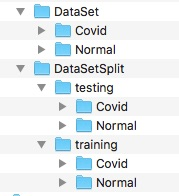


In [ ]:
#Bug no Colab em 08/21
#import splitfolders 
#output = ".../DataSetSplit"
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`. Or training, validation and tste (.8, .1. ,1) or (70,15,15)`
#splitfolders.ratio(DataSet, output="DataSetSplit", seed=1337, ratio=(.8, .2), group_prefix=None) # default values


In [ ]:
path = Path("/content/drive/My Drive/DataSets/IADD/DataSetSplit/")
!touch "/content/drive/My Drive/ping.txt"

In [ ]:
#to list the contents 
path.ls()

(#2) [Path('/content/drive/My Drive/DataSets/IADD/DataSetSplit/training'),Path('/content/drive/My Drive/DataSets/IADD/DataSetSplit/testing')]

# Loading Data

In [ ]:
dls = ImageDataLoaders.from_folder(path=path, 
                                   train='training', 
                                   valid='testing', 
                                   shuffle=True, #Coloca todas as imagens com a mesma resolucao espacial
                                   #448 Ver ref. (1)
                                   item_tfms=Resize(448))

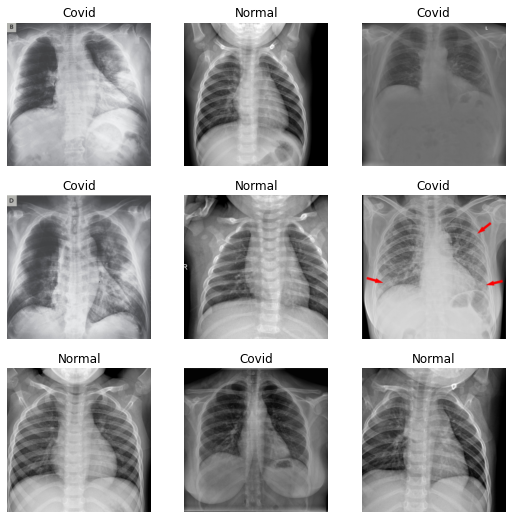

In [ ]:
dls.train.show_batch()

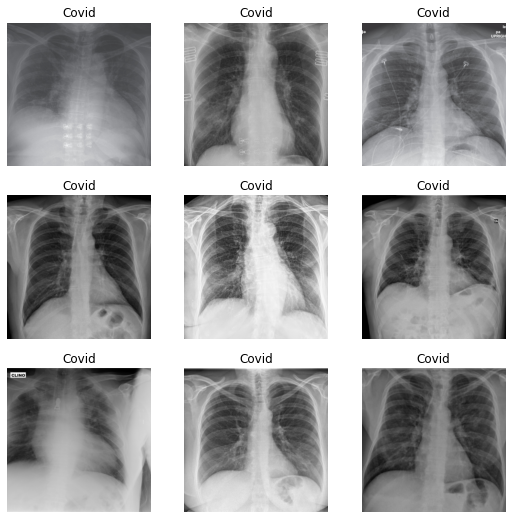

In [ ]:
dls.valid.show_batch()

# Model Training

In [ ]:
import sklearn
import sklearn.metrics as skm

In [ ]:
learn = cnn_learner(dls, 
                    resnet18, 
                    metrics=[accuracy, error_rate])                

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
learn.fine_tune(4)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.105659,1.456094,0.525000,0.475000,01:47


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.096862,0.621982,0.762500,0.237500,00:15
1,0.065667,0.292360,0.875000,0.125000,00:15
2,0.048667,0.127083,0.937500,0.062500,00:15
3,0.035901,0.045126,0.975000,0.025000,00:15


In [ ]:
learn2 = cnn_learner(dls, 
                    resnet34, 
                    metrics=[accuracy, error_rate])

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


In [ ]:
learn2.fine_tune(4)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.940496,0.111447,0.962500,0.037500,00:14


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.076090,0.046128,0.987500,0.012500,00:15
1,0.067106,0.025157,1.000000,0.000000,00:15
2,0.050156,0.003010,1.000000,0.000000,00:15
3,0.040930,0.001814,1.000000,0.000000,00:14


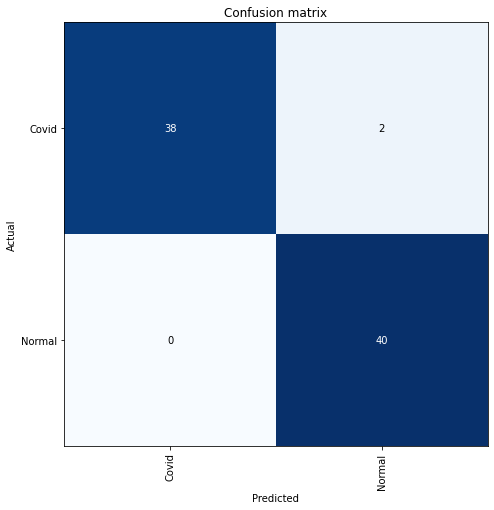

In [ ]:
# Confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(title='Confusion matrix', figsize=(7,7))

In [ ]:
interp.plot_top_losses(10, nrows=2)

NameError: ignored

In [ ]:
#Parametros da Matriz de Confusão
upp, low = interp.confusion_matrix()
VP, FN = upp[0], upp[1]
FP, VN = low[0], low[1]

print(VP, FN, FP, VN) #Dica: VP são as pessoas "Verdadeiramente Doentes", VN "Verdadeiramente NÃO Doentes"

38 2 0 40


# Sensibilidade e Especifidade (Sensitivity and Specificity)

Sensibilidade = Verdadeiro Positivo/(Verdadeiro Positivo + False Negativo)



In [ ]:
Sensibilidade = VP/(VP + FN)
Sensibilidade

0.95

Especificidade = Verdadeiro Negativo/(False Positivo + Verdadeiro Negativo

In [ ]:
Especificidade = VN/(FP + VN)
Especificidade

1.0

# Acuracia: Informa quantos de nossos exemplos foram de fato classificados corretamente, independente da classe. Ex.: Por exemplo, se temos 100 observações e 90 delas foram classificados corretamente, nosso modelo possui uma acurácia de 90%.
Ref.: https://medium.com/kunumi/métricas-de-avaliação-em-machine-learning-classificação-49340dcdb198

In [ ]:
preds,y, loss = learn.get_preds(with_loss=True)
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc))

The accuracy is 0.9750000238418579 %.


AUC — Area Under the Curve ou AUROC — Area Under the Receiver Operating Characteristic curve): vantagem desta métrica é que ela não é sensível ao desbalanço de classes, como ocorre com a acurácia.

In [ ]:
from sklearn.metrics import roc_curve, auc
# probs from log preds
probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))

ROC area is 1.0


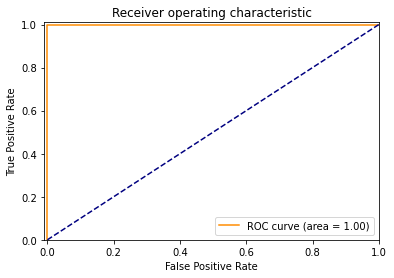

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")